# MNIST Dataset 

* Dataset used to prove image recognition can be done with machine learning
* Images are grayscale 28 x 28
* Digits 0-9
* Goal here is OCR (Optical Character Recognition)
* What do these images look like?

In [1]:
# FINALLY SOME CODE!
# Import time - tensorflow, numpy (a numerical library very common in scientific applications) and plotting library.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# MNIST is a small dataset so we don't need GPU. These next two lines force tensorflow to use the CPU.
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #Force running on CPU since this is a small network
from AccuracyHistory import AccuracyHistory #locally defined class, don't worry about the workings of this now

2025-04-25 10:25:35.550898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 10:25:35.595995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 10:25:35.596027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 10:25:35.597181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 10:25:35.603952: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# MNIST is a classic learning dataset and is provided as part of tensorflow.
# It will be automatically downloaded if you do not have it already.
mnist = keras.datasets.mnist

# If you want to check you're using a GPU, include the following:
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# print(physical_devices)
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())


# Train and test partition split

* As mentioned before, this must be done to properly judge model performance
* MNIST knows you want to do this
* Data preprocessing is done for you here but can be a very manual and time consuming process
* We will have future presentation

In [4]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print(train_images.shape)

(60000, 28, 28)


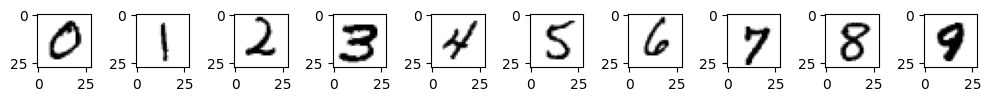

In [5]:
# BUT WHAT DO THEY LOOK LIKE? I looked at mnist and found indexes with a sample of each digit
numerical_indexes = [1,8,122,111,9,332,4572,223,333,1333]
# Finally we will answer what these images look like.
fig, axes = plt.subplots(1, 10, figsize=(10,10))
for n in range(0,len(numerical_indexes)):
    axes[n].imshow(train_images[numerical_indexes[n]],  cmap=plt.cm.binary)
plt.tight_layout()
plt.show()

In [6]:
# Verify labels
print(train_labels[numerical_indexes])
# dimensions of one image
train_images[333].shape

[0 1 2 3 4 5 6 7 8 9]


(28, 28)

# Is dataset balanced?

* By which we mean, are all classes represented equally?
* A dataset that is imbalanced can lead to many different problems.
* e.g. You are doing binary classification so your classes are 0 or 1. Your dataset is 95% 0.
* A model can get a very good score just by predicting 0 all the time.

In [7]:
class_counts = np.zeros(10) #MNIST is for digits 0-9 for total of 10
for i in range(len(train_labels)):
    class_counts[train_labels[i]] += 1
for i in range(len(class_counts)):
    print(i, ":", str(class_counts[i] / len(train_labels)))

0 : 0.09871666666666666
1 : 0.11236666666666667
2 : 0.0993
3 : 0.10218333333333333
4 : 0.09736666666666667
5 : 0.09035
6 : 0.09863333333333334
7 : 0.10441666666666667
8 : 0.09751666666666667
9 : 0.09915


In [8]:
# Mnist does require one preprocessing step which we do below.
# The reasons why will be discussed in future courses.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Side note:

* We are going to change the shape of our images so we can use a special plotting library at the end
* This library requires images to have 3 "dimensions."
* MNIST images are 28x28 but we are going to reshape them to 28x28x1
* This is because most pictures used in convolutional neural networks have 3 values per pixel (RGB)
* MNIST images are grayscale so only have a single value per pixel.


In [9]:
print("Before reshape", train_images.shape)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)
print("After reshape", train_images.shape)

Before reshape (60000, 28, 28)
After reshape (60000, 28, 28, 1)


# Define model

* Recall diagram - Models are made of multiple layers, each of which contains a number of units.
* How many layers? How many hidden units in each layer? 
* Some tips to start: keep it simple. Simpler networks generalize better (similar performance to train and test data).

# Defining First layer

<img src="../images/Backprop.jpg" width="400" height="400" align=right />

* First layer must be equal in size to an individual item in your dataset.
* We will specify the 28 x 28 resolution of each individual image in mnist.

# Defining Second layer

* The number of hidden units should be between the size of the input layer and the size of the output layer
* If you want an exact formula, sadly there isn't one.

# Third layer

* For MNIST, this will be the number of categories of our target. How many do we have?
  
# Output Layer

* This network will output a series of raw prediction numbers (aka logits) for each class
* Q: What if we want probabilities rather than raw numbers?
* A: Add a softmax layer to this. We will do that later in this notebook

In [10]:
#This is basically one line in Keras
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape), # MNIST images are 28 x 28, Flatten turns this into 1-D array of 784 (28 x 28)
    keras.layers.Dense(128, activation='relu'),              # 128 is between 784 and 10.
    keras.layers.Dense(10),                                  # We want to finish with 10 because we have 10 possible classes.
    keras.layers.Softmax()                                   # Converts raw math numbers to human-readable probabilities that sum to 1
])

# In Tensorflow, creating model topology is the first step

* Now we have to deal with the other components I mentioned
* Pop quiz - what were they?
  

# Loss function 
* If your data is all 0s or 1s, you would use BinaryCrossentropy
* If you have multiple classes, you would want either CategoricalCrossentropy or SparseCategoricalCrossentropy
* If you were doing regression, you would probably use MeanSquaredError

# What are our targets?


In [11]:
# What kind of targets do we have and how are they encoded?
np.unique(train_labels)
# What should we use from the above?

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Answer

* Because the labels are from 0-9, this means we should use SparseCategoricalCrossentropy
* If label looked like [0,0,1,0,0,0,0,0,0,0] indicating 2 (also known as one-hot encoding), 
 we would use CategoricalCrossentropy.
* Next step after model creation is compilation

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Epochs

* Epochs are how many times we do the training loop from the diagram above
* This has a dramatic effect on training time
* if you don't curtail it with EarlyStopping, which we will discuss briefly but not implement.

In [13]:
epochs=3
history=AccuracyHistory() #User made class we will discuss later
model.fit(train_images, train_labels, epochs=epochs, callbacks=[history]) # fit means train, old terminology

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2592 - sparse_categorical_accuracy: 0.9267
Epoch 2/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9666
Epoch 3/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9772


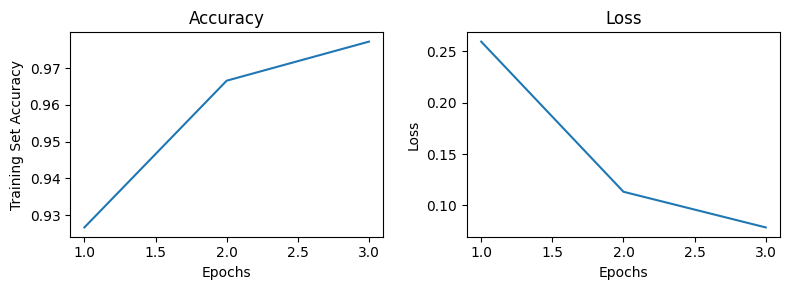

In [14]:
#Plot accuracy and loss graphs
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(range(1, epochs + 1), history.acc)
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Training Set Accuracy')

axes[1].plot(range(1, epochs + 1), history.loss)
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Analysis
* MNIST is a simple problem that was pretty well learned after 2 epochs
* It gives us the classic graphs of what SHOULD happen - accuracy goes up over time and loss goes down over time
* Too much training can result in overfitting
* your model's training performance looks good but it does not generalize well on test data.

# Speaking of which, time for the moment of truth

* How well does this model do on test data it has not seen before?

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.0803 - sparse_categorical_accuracy: 0.9734 - 418ms/epoch - 1ms/step

Test accuracy: 0.9733999967575073


# Pretty good!

* If this number was significantly lower than our training accuracy, that would indicate overfitting.

In [16]:
np.set_printoptions(suppress=True)
predictions = model.predict(test_images)
print(predictions[3])

313/313 [==============================] - 0s 946us/step
[0.9975502  0.00002884 0.00107899 0.00002324 0.00000333 0.00031516
 0.00059793 0.00024893 0.00000081 0.00015253]


# Probabilities are more human readable

* Probabilities for each class are good for seeing where your model might be getting confused

# Black Box problem

* For years, machine learning has been criticized for being a black box. 
* Seeing a probability is nice but in many cases, we will want to know why the model decided as it did. 
* For instance, there can be discrimination possibilities if a model uses certain information.
* Legally protected information should be left out of a model entirely but as we see with AI, many times questionable sources are used in model training.

# Shapley values to the rescue

* Shapley values use permutation-based game theory to open the black box and see why a model decided as it did.

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


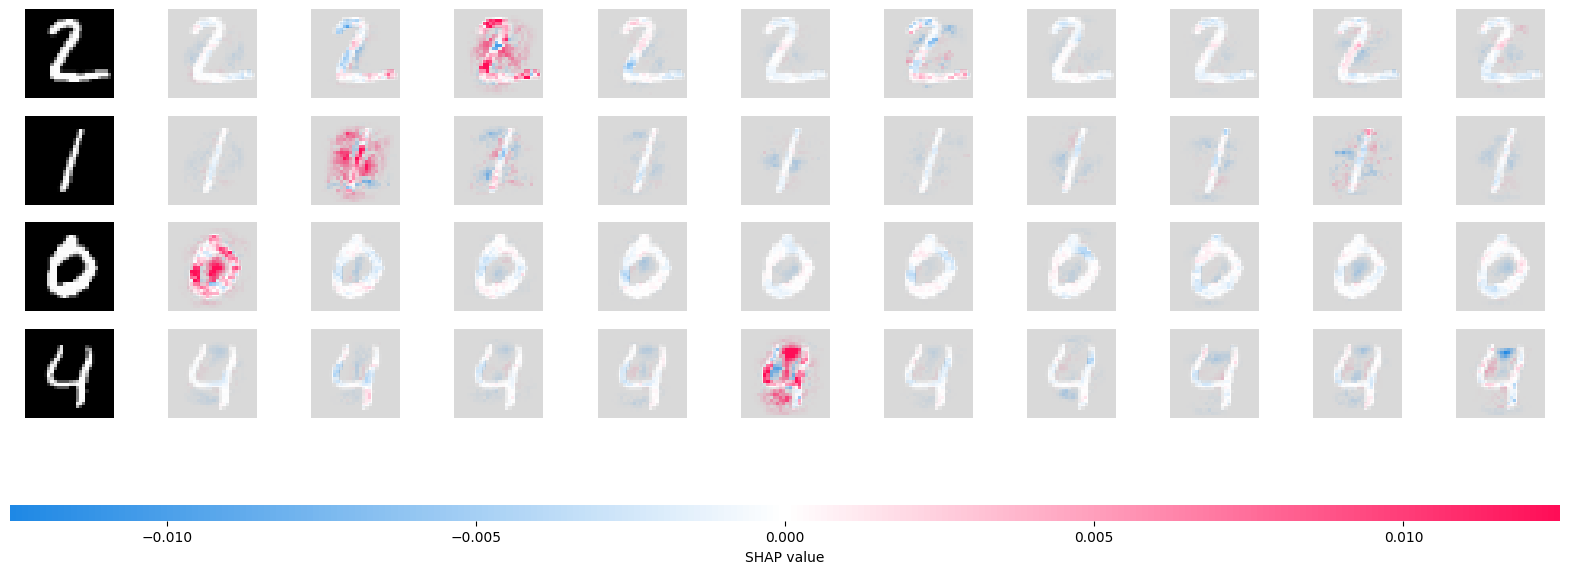

array([[0.0000003 , 0.00060787, 0.99913365, 0.00009566, 0.        ,
        0.00002273, 0.00000057, 0.        , 0.0001392 , 0.        ],
       [0.00000499, 0.99002993, 0.00344804, 0.00007569, 0.0009867 ,
        0.00016156, 0.00032946, 0.00236857, 0.00255058, 0.00004452],
       [0.9975502 , 0.00002884, 0.00107899, 0.00002324, 0.00000333,
        0.00031516, 0.00059793, 0.00024893, 0.00000081, 0.00015253],
       [0.00000647, 0.00000453, 0.00011272, 0.00000991, 0.98127764,
        0.00000538, 0.00008352, 0.00039377, 0.00043833, 0.01766777]],
      dtype=float32)

In [17]:
import shap
background = train_images[np.random.choice(train_images.shape[0], 4000, replace=False)]
e = shap.DeepExplainer(model, background) # train_images)
# Get the values. Ranked_outputs = 2 means the two highest ranked possible classes for each image.
shap_values = e.shap_values(test_images[1:5])
# plot the feature attributions
# Red pixels represent positive SHAP values that increase the probability of the class, 
# while blue pixels represent negative SHAP values the reduce the probability of the class
shap.image_plot(shap_values, test_images[1:5]) #, index_names)
predictions[1:5]

(28, 28, 1)


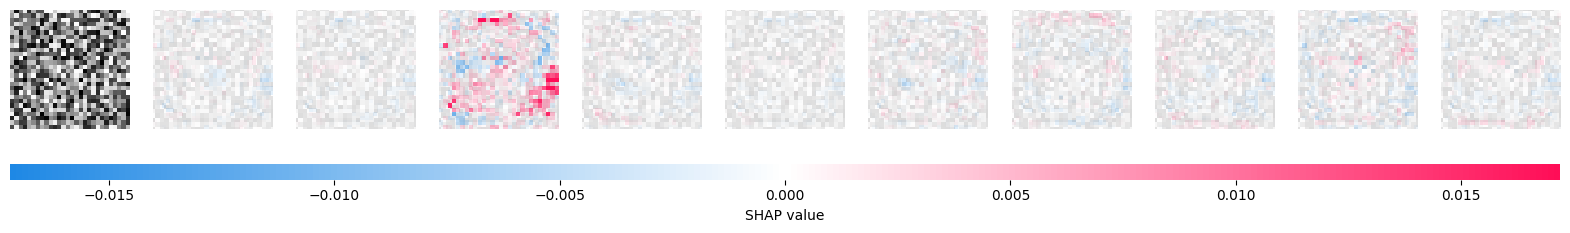

1/1 [==============================] - 0s 17ms/step
[[0.00000025 0.         0.9427012  0.01128043 0.         0.03732321
  0.00035311 0.00000161 0.00833998 0.00000019]]


In [18]:
#But what if some of your data is bad? Let's look at a randomly generated image.
randomImg = np.array([np.random.rand(28,28)])
randomImg = randomImg.reshape(28,28,1)
print(randomImg.shape)
randomImg = np.array([randomImg])
random_shapvalues = e.shap_values(randomImg)
shap.image_plot(random_shapvalues, randomImg)
print(model.predict(randomImg))

# What if we do something wrong?
* MNIST is categorical but what if we treated it like regression?

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape), # MNIST images are 28 x 28, Tensorflow prefers 1-D of 784 (28 x 28)
    keras.layers.Dense(128, activation='relu'), # 128 is between 784 and 10.
    keras.layers.Dense(1)                      # Before this was 10. Regression is only one number, not a series of categories.
    #keras.layers.Softmax()                    # No softmax because no classification categories
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss=keras.losses.MeanSquaredError(), #SparseCategoricalCrossentropy(from_logits=False), 
              metrics=[keras.metrics.MeanSquaredError()]) #SparseCategoricalAccuracy()])

model.fit(train_images, train_labels, epochs=epochs)

Epoch 1/3
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0195 - mean_squared_error: 2.0195
Epoch 2/3
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0142 - mean_squared_error: 1.0142
Epoch 3/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.8245 - mean_squared_error: 0.8245


In [20]:
test_loss, test_mse = model.evaluate(test_images, test_labels, verbose=2) # The tuple here are identical because regression
print('\nTest MSE:', test_mse) 


313/313 - 0s - loss: 0.8171 - mean_squared_error: 0.8171 - 334ms/epoch - 1ms/step

Test MSE: 0.8170532584190369


In [21]:
#What does this even mean? How would we measure success?

predictions = model.predict(test_images)
for i in range(10):
    print(predictions[i], test_labels[i])

313/313 [==============================] - 0s 858us/step
[6.4268923] 7
[2.1879926] 2
[1.106993] 1
[0.7752695] 0
[4.5432615] 4
[0.9608109] 1
[4.466629] 4
[7.353363] 9
[6.816218] 5
[8.275578] 9


# Problems you might have

* One of the problems above - bad data, incorrect choices
  

# Overfitting

* good training performance but bad test performance

* Decrease complexity of model (units, layers, features, etc.), early stopping, cross-validation 

# Underfitting

* Bad training and test performance

* Opposite of above - increase model complexity, get more data if possible

# Hyperparameters - the last refuge...

* Learning rate, optimizer choice, activation function, many more we haven't mentioned
  
* Hyperparameters optimization – is “because it works” good enough?

* Impossible tasks – AI/ML can’t do everything